# Characteristics of Countries that correlate with use of nuclear energy

This notebook will be used to document the exploration of the question:

_"Are there characteristics of a country that correlate with increases or decreases in
the use of nuclear energy?"_

In order to gather information about this topic, we are going to use the "World Values Survey" (WVS).
It is a dataset that records various psychological effects and phenomena of citizen from various countries.
The data in the WVS is collected from the World Value Study and the European Value Study. Hence, some
questions/features included in the dataset are not available for certain countries.
Data is collected in 5-Year intervals. This is important to know, as merging the data on years with other
datasets will require some tweaking of the granularity of the time data (5-year versus 1-year etc.).

For the nuclear energy part, we are going to rely on the "Our World in Data - Energy" (OWID) dataset. We
also use this dataset for a few other questions we try to answer. It contains yearly information about
various energy features, including nuclear, renewable, coal and many more. We are going to focus solely
on the nuclear energy related features to research this question.

## Loading the data
As first step, we will import all the python packages we are going to use later on.
We also import the datasets from .sav and .csv respectively. The .sav file is generated
using IBM's SPSS software according to the WVS guide.

In [3]:
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [139]:
df, meta = pyreadstat.read_sav("data/VWS/Integrated_values_surveys_1981-2021.sav", encoding="cp850")

In [5]:
owid = pd.read_csv("data/OWID_energy/owid-energy-data.csv")

### Pre-Processing for WVS

As first step, we divide the years into intervals of 5-years.
This should make processing the data a bit easier.

We then collect the data from 1980 and 1985 into one interval, as there
are very few values recorded in 1985 (See exploration notebook).

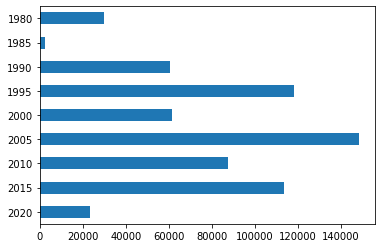

In [273]:
(df["S020"].astype(int)//5 * 5).value_counts().sort_index(ascending=False).plot.barh()
df["year"] = (df["S020"].astype(int)//5 * 5)
df.loc[df["year"] == 1985,'year'] = 1980

We can see that amount of data recorded between the years varies greatly.
This may impact our analysis going forward if we use years with low number of responses.

Since the country codes are saved in a separate tab-separated-values file,
we will have to read them into our dataframe as well.

In [274]:
iso_codes = pd.read_csv("data/VWS/iso country codes/iso3166.tsv", sep="\t")
iso_codes["Numeric"] = iso_codes["Numeric"].fillna(0).astype(int)
alpha2_to_alpha3 = iso_codes.set_index("Alpha-2 code")["Alpha-3 code"].to_dict()

def map_codes(alpha2val):
    if alpha2val in alpha2_to_alpha3:
        return alpha2_to_alpha3[alpha2val]
    else:
        return "invalid"

df["country"] = df["S009"].apply(map_codes)

As the dataset is very huge and has a lot of features, we will only be able
to analyse a select few that we deemed appropriate with our limited time.
The features from the WVS that in our opinion could influence the usage
of nuclear energy are (not limited to) the following:

In [275]:
relevant_nuclear_features = [
                             'E105', #Aproval of Anti-Nuclear Movement
                             'E069_11', #Confidence in the Government
                             'E069_03', #Confidence Education System
                             'E001', #Aims of country first choice
                             'E022', #Opinion about scientific advances
                             'E016', #Future changes: More emphasis on technology
                             'B008', #Protecting Env. vs Economic Growth
                             'B007', #Protecting Env and fighting pollution is less urgent
                             'B005', #All talk about the environment make people anxious
                             'B003', #Government should reduce environmental pollution
                             'A071B', #Member: Belong to conservation, the environment, ecology
                             ]

As the data in the WVS is a questionare format, it is a good idea to first pre-process them via the codes
and throw out any answer we can not use for our analysis (non-answer, other than listed answer, etc.)

### Handling missing data

We will see that the data has lots and lots of missing values, due to people not being asked certain questions
anymore depending on year and/or country.

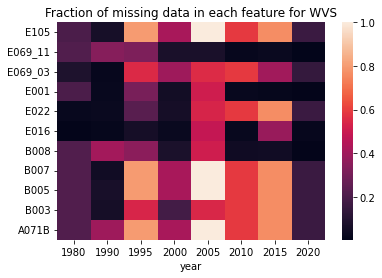

In [303]:
wvs_interesting = df.loc[:, relevant_nuclear_features + ['country', 'year']]
missing_by_interval = df[relevant_nuclear_features].applymap(lambda x: x if x > 0 else np.nan).isna().groupby(df.year)
non_responses = (missing_by_interval.sum() / missing_by_interval.count().max()).T
miss_ax = sns.heatmap(non_responses)
miss_ax.set_title("Fraction of missing data in each feature for WVS");

We can see that some features mainly consist of missing values.
For the features affected, it is probably best to exclude them from this analysis, as imputation would
introduce gigantic bias. Most of the missing data can be attributed to the questions just not being asked (or are
answered for that matter). This is unfortunate, as some of them would be interesting to analyse,
such as E105. The same goes for B003, B007, B069_03 and A071B.

For other columns the missing data is manageable, but also can be attributed to the same issues.

Since they are very interesting and may be very relevant for the analysis.
For the columns with large numbers of NAs, we will drop them:

In [302]:
wvs_cleaned = wvs_interesting.loc[:, ~wvs_interesting.columns.isin(["B005","B003","B007","A071B","E105","E069_03"])]

There is also a country 'invalid' that we have to remove:

In [339]:
wvs_cleaned = wvs_cleaned.loc[~(wvs_cleaned.reset_index().country == 'invalid').values, :]

In order to get a better overview of the data over the timeframes, we will just take the
averages of the columns. Since most of them are codes ordered from ae. 1-4 for good-bad government,
it makes sense to do so.

In [340]:
wvs_clean_agg = wvs_cleaned.groupby(['country','year']).mean()
wvs_clean_agg

E069_11      E001      E022      E016      B008
country year                                                  
ALB     1995  2.611778  1.226358  1.361081  1.206445  1.570608
        2000  2.380952  1.252041  1.863687  1.412000  1.562570
        2005  3.030780       NaN       NaN       NaN       NaN
        2015  3.391152  1.542160       NaN       NaN  1.538462
AND     2005  2.783838  2.625126  1.864919  1.534673  1.229525
...                ...       ...       ...       ...       ...
ZAF     2010  2.560105  1.912489       NaN  1.588521  1.639196
ZMB     2005  2.592287  1.560647  1.509615  1.606628  1.640969
ZWE     2000  2.443730  1.675403  1.386803  1.279441  1.667010
        2010  2.533333  1.475333       NaN  1.283333  1.625333
        2020  2.530629  1.745679       NaN  1.134488  1.465174

[386 rows x 5 columns]

We still get a few NAs, for them will just use imputation, as for most
countries there are not that many NaNs per feature.

In [341]:
wvs_clean_agg = wvs_clean_agg.fillna(wvs_clean_agg.interpolate())

## Economic Growth versus Protecting the Environment



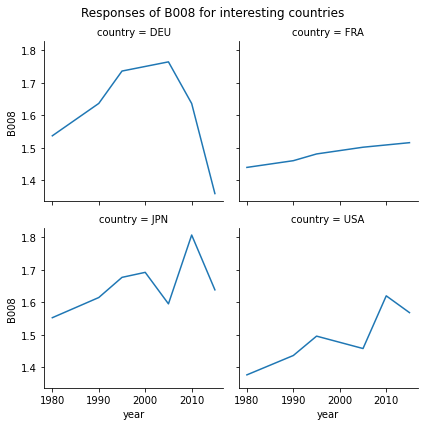

In [342]:
comp_countries = ['JPN','DEU','USA','FRA']
nuc_comp = wvs_clean_agg.reset_index()
nuc_comp = nuc_comp.loc[nuc_comp.country.isin(comp_countries),:]
g = sns.FacetGrid(nuc_comp, col="country", col_wrap=2)
g.map_dataframe(sns.lineplot, x="year",y="B008")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Responses of B008 for interesting countries');

We can see that for most countries, the trend goes towards more economic orientation, expect for
Germany. The experience a steep drop to protecting the environment (closer to 1) after 2005. There
may some interesting phenomena at this point in time.

For the other countries, we only see a drop for Japan after the reactor accident in Fukushima (2011)
occurred.

There are certain Movements like 'Atomkraft:Nein' that were/are very prominent in german speaking countries. This may have an effect on this orientation.
To further analyse this, we could also look at the values over time to get insight when/if something changes at some point.

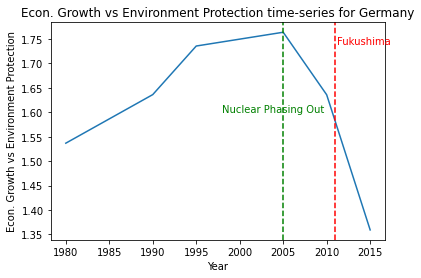

In [343]:
ax = sns.lineplot(x=nuc_comp.year, y=nuc_comp.loc[nuc_comp.country == 'DEU','B008'])

plt.axvline(x=2011, label="Fukushima Disaster", color="red", linestyle="--")
plt.text(2011.2, 1.74,'Fukushima',c="red")

plt.axvline(x=2005, label="Nuclear Phasing Out", color="green", linestyle="--")
plt.text(1998, 1.6,'Nuclear Phasing Out',c="green")

ax.set_title("Econ. Growth vs Environment Protection time-series for Germany")
ax.set_ylabel("Econ. Growth vs Environment Protection")
ax.set_xlabel("Year");

We can see a pretty clear trend down towards 'Protecting environment'.
Interestingly, this change starts at around 2005. If we research the year 2005, this is the start of the 'phasing-out' phase for nuclear energy. 

This was initiated by the German Green Party, which is heavily anti-nuclear energy. For reference, see this BBC article from back then: http://news.bbc.co.uk/1/hi/world/europe/4295389.stm

# Combining with Our World in Data Energy Dataset

## Preprocessing and Merging with WVS

### OWID Energy
As a first step we will pull out all features that are relevant for
nuclear power related to countries. These include the following:

In [328]:
nuclear_vars = [
    'nuclear_share_elec',
    'nuclear_cons_change_pct',
    'nuclear_share_energy',
    'nuclear_cons_change_twh',
    'nuclear_consumption',
    'nuclear_elec_per_capita',
    'nuclear_energy_per_capita',
    'nuclear_electricity',
    'primary_energy_consumption'
]

identifier = [
    'country',
    'year',
    'iso_code'
]
owid_nuc = owid.loc[:, owid.columns.isin(nuclear_vars + identifier)]
owid_nuc = owid_nuc.set_index('country')
owid_nuc['nuclear_comp_share_percent'] = owid_nuc["nuclear_consumption"] / owid_nuc["primary_energy_consumption"] * 100

There seem to be quite a few NAs in the selected data.
We should figure out a way to sensibly remove/replace them or find out where they come from. 

We can find explanations for the missing data on the OWID website. They conclude that most of the missing data is either locked or non-public (I would guess the OPEC, e.g. Oil orginaisation containing the Arab Emirates, Afghanistan etc.). THey also mention lower-income countries mostly do not report their data, or the data is in bad shape (due to lacking resources in this regard would be a guess). For a more detailed report please refer to https://ourworldindata.org/energy-missing-data

We also see this confirmed if we actually look at the grouped means of average
missing values per country below:

In [330]:
missing_nuc_data = owid_nuc.isna().groupby('country').sum().mean(axis=1).sort_values(ascending=False)
missing_nuc_data.head(5)

country
Yugoslavia        106.250000
Czechoslovakia    106.166667
OPEC              104.166667
Middle East        99.583333
Myanmar            96.916667
dtype: float64

Before merging with the WVS, we should also take a look to see
if the years, as we are going to have to aggregate them for the
OWID set (since WVS only has time instances every 5 years).

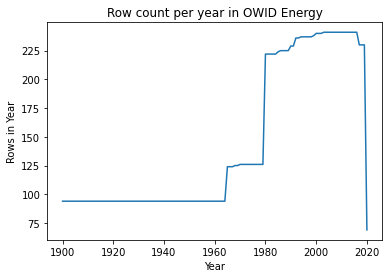

In [331]:
owid_years_counts = owid_nuc.year.value_counts().sort_index()
ax = sns.lineplot(y=owid_nuc.year.value_counts().sort_index(), x=owid_years_counts.index)
ax.set_title("Row count per year in OWID Energy")
ax.set_xlabel("Year")
ax.set_ylabel("Rows in Year");

We can see OWID Energy has data for every year, with more
rows being available after around 1980. Since the WVS's recordings
starts only in 1980, we won't really need the data before that
point in time.

In [332]:
owid_cut = owid_nuc.loc[owid_nuc.year >= 1980, :]

In order to match the WVS's format, we will also proceed and average
the values of OWID Energy over a time horizon of 5 years, starting with 1980.
For this, we group by country and add a rolling average over 5 years for all countries.
We then take only those year averages out that are in the range of the WVS's years, then
add some new indices and suffixes for the columns.

In [415]:
valid_years = df.year.unique()
owid_agg = owid_cut.groupby('iso_code').rolling(5, min_periods=1).mean()
owid_agg = owid_agg.loc[owid_agg.year.isin(valid_years), :]
owid_agg = owid_agg.set_index('year', append=True).add_suffix("_avg")

### Imputation for NAs

For this dataset the NAs come from data being not accessible or countries not having any reactors at all.
There is a description of the issue on the OWID website for further reference. Because of this, we will just
try to interpolate what we have per group. If a country has no values that can be interpolated (e.g. data not available),
we drop them out. It now looks like a lot of data is dropped, but much of the data is not recorded in the first place (eg.
poorer countries, OPEC, ...) that was not relevant anyways.

In [416]:
owid_agg_cleaned = owid_agg.groupby('country').apply(lambda group: group.interpolate(method='linear', limit_direction='backward').dropna())
owid_agg_cleaned = owid_agg_cleaned.reset_index(level=0).drop('country',axis=1)

### Merging OWID and WVS

We can finally create a merged dataframe using both the country code and year as keys.
Since we aggregated the values beforehand, we greatly reduced the in-memory size of combined the dataframe.
(before it was around ~4GB in memory).

In [423]:
merged_all = pd.merge(owid_agg_cleaned.reset_index(), wvs_clean_agg.reset_index(), left_on=['iso_code','year'], right_on=['country','year'])
merged_all = merged_all.rename(columns={"country_x":"country"}).drop("country_y",axis=1)
merged_all = merged_all.set_index(['iso_code','country','year'])
merged_all

nuclear_electricity_avg  \
iso_code country       year                              
ARG      Argentina     1980.0                   6.5910   
                       1990.0                   6.5910   
                       1995.0                   7.6942   
                       2005.0                   6.9176   
                       2010.0                   6.5856   
...                                                ...   
USA      United States 1990.0                 603.0588   
                       1995.0                 679.4750   
                       2005.0                 785.5782   
                       2010.0                 794.3132   
                       2015.0                 798.8008   

                               nuclear_share_elec_avg  \
iso_code country       year                             
ARG      Argentina     1980.0                 12.4498   
                       1990.0                 12.4498   
                       1995.0                 11.4548   
                       2005.0                  6.8830   
                       2010.0                  5.4952   
...                                               ...   
USA      United States 1990.0                 19.0040   
                       1995.0                 19.0850   
                       2005.0                 19.5152   
                       2010.0                 19.5270   
                       2015.0                 19.5632   

                               nuclear_cons_change_pct_avg  \
iso_code country       year                                  
ARG      Argentina     1980.0                     -13.0760   
                       1990.0                       3.7812   
                       1995.0                       2.7604   
                       2005.0                       4.8544   
                       2010.0                      -2.6994   
...                                                    ...   
USA      United States 1990.0                       6.4758   
                       1995.0                       0.4166   
                       2005.0                       0.0492   
                       2010.0                      -1.5364   
                       2015.0                       0.3130   

                               nuclear_share_energy_avg  \
iso_code country       year                               
ARG      Argentina     1980.0                    1.4120   
                       1990.0                    3.4584   
                       1995.0                    3.4822   
                       2005.0                    2.6092   
                       2010.0                    2.0868   
...                                                 ...   
USA      United States 1990.0                    7.4652   
                       1995.0                    7.7716   
                       2005.0                    8.3402   
                       2010.0                    8.5466   
                       2015.0                    8.2940   

                               nuclear_cons_change_twh_avg  \
iso_code country       year                                  
ARG      Argentina     1980.0                      -0.9780   
                       1990.0                       0.3422   
                       1995.0                       0.4888   
                       2005.0                       0.6616   
                       2010.0                      -0.5558   
...                                                    ...   
USA      United States 1990.0                      95.6174   
                       1995.0                       5.7706   
                       2005.0                       0.6696   
                       2010.0                     -33.7800   
                       2015.0                       6.4762   

                               nuclear_consumption_avg  \
iso_code country       year                              
ARG      Argentina     1980.0       

## Correlations

We could now try to find correlations between the nuclear energy and the country characteristics of the world value survey.
For this purpose, we will select the feature-subsets (A,B, ...) from the WVS and compute their correlations to the OWID's
nuclear features.

To make selection and model analysis a bit easier, we define a few helping function that compute the correlations
and significant correlations for us. If we find significant variables in a subset, we can always get more details.

In [87]:
def create_merged_feature_subset(feature_letter):
    characteristics = [col for col in merged_all if col.startswith(feature_letter)]
    owid_merged_characteristics = merged_all.loc[:, merged_all.columns.isin(owid_agg.columns.tolist() + characteristics)]
    corrs = owid_merged_characteristics.corr()
    return owid_merged_characteristics, corrs

def evaluate_correlation_matrix(corr_matrix, label):
    filtered_corrs = filter_correlation_by_owid_features(corr_matrix)
    is_subset_significant = np.abs(filtered_corrs) >= 0.7
    characteristics_significant_count = is_subset_significant.sum().sum()
    print(f"Amount of significant correlations between WVS {label} features and nuclear energy features: {characteristics_significant_count}")

def draw_nuclear_heatmap(corrs, label):
    filtered_corrs = filter_correlation_by_owid_features(corrs)
    plt.figure(figsize=(15,4))
    ax = sns.heatmap(filtered_corrs)
    ax.set_title(f"Significant correlation of {label} and Nuclear Energy Features");

def filter_correlation_by_owid_features(corr):
    owid_features = owid_agg.columns.tolist()
    return corr.loc[corr.index.isin(owid_features), ~corr.columns.isin(owid_features)]

def analyse_correlation_for_subset(feature_symbol, label):
    subset, sub_corr = create_merged_feature_subset(feature_symbol)
    draw_nuclear_heatmap(sub_corr, label)
    evaluate_correlation_matrix(sub_corr, label)
    return subset, sub_corr

# TODO: Add this part again ...

## Testing using ML and feature selection

Since we found no significant direct correlation between any of the characteristics of the world value survey (1981-2021), another idea would be to try to predict some of the nuclear variables using machine learning. There may a not a single characterstic that is good enough to 'predict' the nuclear energy features like we tested before, but a combination of multiple.

For this reason we could apply a regression algorithm and feature selection on the merged data to see if any combination of features gives us the ability to predict the nuclear features. 

For sake of simplicity, we are first going to start using linear methods like Lasso or Ridge Regression that do regression with built in feature-selection. To get the benefits of both methods, we are going to use ElasticNet and search for fitting parameters using GridSearch.

### ElasticNet Model

In [424]:
target = merged_all.loc[:, 'nuclear_comp_share_percent_avg']
features = merged_all.drop('nuclear_comp_share_percent_avg', axis=1)
features = features.loc[:,~features.columns.str.startswith('nuclear')]
features = features.drop('primary_energy_consumption_avg', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target)

regressor = ElasticNetCV(cv=5, random_state=0)
regressor.fit(X_train, y_train)

ElasticNetCV(cv=5, random_state=0)

RMSE: 56.03405775734091


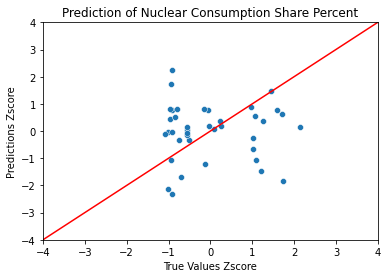

In [425]:
def evaluate_model(model, xtest, ytest):
    predictions = model.predict(xtest)
    ax = sns.scatterplot(x=(ytest - ytest.mean())/ ytest.std(), y=(predictions - predictions.mean())/ predictions.std())
    ax.axline((0,0),(1,1),c="red")
    ax.set_title("Prediction of Nuclear Consumption Share Percent")
    ax.set_xlabel("True Values Zscore")
    ax.set_ylabel("Predictions Zscore")
    ax.set(xlim=(-4,4))
    ax.set(ylim=(-4,4))
    print(f"RMSE: {mean_squared_error(y_test, predictions)}")

evaluate_model(regressor, X_test, y_test)

The predictions don't seem very good. Most of them are on
show systematic differences from the optimal line between
predictions and true values. We see quite a few outliers everywhere.

We could now also look at which variables were selected by ElasticNet:

In [429]:
def get_sorted_coefficients(model, trainingset, n=10):
    coefs = pd.Series(model.coef_)
    coefs.index = trainingset.columns
    print(coefs.abs().sort_values(ascending=False).head(n))

get_sorted_coefficients(regressor, X_train)

B008       10.497849
E016        7.185875
E069_11     5.518731
E001        2.472035
E022        0.550037
dtype: float64


But, as we expected from previous analysis, B008 (Economy vs Environment) is the
model's largest coefficient, directing the predictions. Even though the predictions
are not very good, we can see that this feature seems to be a driving factor for using
nuclear energy.